<a href="https://colab.research.google.com/github/Muhammadsulton1/ML/blob/main/telecoma_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

In [2]:
!pip install lightgbm

In [3]:
!pip install xgboost

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score,f1_score

In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


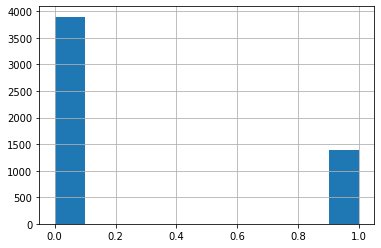

In [7]:
data['Churn'].hist();

In [8]:
data.describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


In [9]:
data.tail()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0
5281,19,75.90,1375.6,Female,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,0


In [10]:
data.isna().sum() / data.shape[0]

ClientPeriod                0.0
MonthlySpending             0.0
TotalSpent                  0.0
Sex                         0.0
IsSeniorCitizen             0.0
HasPartner                  0.0
HasChild                    0.0
HasPhoneService             0.0
HasMultiplePhoneNumbers     0.0
HasInternetService          0.0
HasOnlineSecurityService    0.0
HasOnlineBackup             0.0
HasDeviceProtection         0.0
HasTechSupportAccess        0.0
HasOnlineTV                 0.0
HasMovieSubscription        0.0
HasContractPhone            0.0
IsBillingPaperless          0.0
PaymentMethod               0.0
Churn                       0.0
dtype: float64

In [11]:
data['TotalSpent'] = data['TotalSpent'].replace(" ", np.nan)
data.dropna(inplace=True)

In [12]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [13]:
cat_cols = []
num_cols = []
for col in data.columns:
  if data[col].dtype == 'object':
    cat_cols.append(col)
  else:
    num_cols.append(col)

#попарное соединение признаков

In [14]:
for i, col1 in enumerate(cat_cols):
  for j, col2 in enumerate(cat_cols[i + 1:]):
    data[col1 + '_' + col2] = data[col1] + '_' + data[col2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


#кодирование категориальных признаков средним значением 

In [15]:
for col in data.columns:
  if data[col].dtype == 'O' and data[col].nunique() > 3:
    mean_encode = data.groupby(col)['Churn'].mean()
    data.loc[:, col] = data[col].map(mean_encode)

In [16]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasOnlineTV_HasMovieSubscription,HasOnlineTV_HasContractPhone,HasOnlineTV_IsBillingPaperless,HasOnlineTV_PaymentMethod,HasMovieSubscription_HasContractPhone,HasMovieSubscription_IsBillingPaperless,HasMovieSubscription_PaymentMethod,HasContractPhone_IsBillingPaperless,HasContractPhone_PaymentMethod,IsBillingPaperless_PaymentMethod
0,55,19.50,0.0,Male,0,Yes,Yes,Yes,No,No,...,0.072120,0.025735,0.063291,0.089054,0.025735,0.063291,0.089054,0.075820,0.049383,0.138810
1,72,25.85,0.0,Male,0,Yes,No,Yes,Yes,No,...,0.072120,0.006329,0.063291,0.029046,0.006329,0.063291,0.029046,0.013413,0.018349,0.102725
2,1,75.90,1.0,Male,0,No,No,Yes,No,Fiber optic,...,0.346280,0.436316,0.393050,0.487242,0.443433,0.400152,0.500615,0.481292,0.525714,0.494665
3,32,79.30,0.0,Female,1,Yes,No,Yes,Yes,Fiber optic,...,0.346280,0.436316,0.237858,0.283516,0.443433,0.234211,0.301552,0.301342,0.328788,0.138810
4,60,115.25,0.0,Female,0,Yes,Yes,Yes,Yes,Fiber optic,...,0.285811,0.043860,0.181308,0.151639,0.042589,0.190311,0.166008,0.013413,0.018349,0.102725


In [17]:

# Создаем объект label encoder для преоброзования категориальных признаков в числовые
le = LabelEncoder()
le_count = 0
# Проходим по всем столбцам
for col in data:
    if data[col].dtype == 'object':
        # Если признак имеет 12 или менее уникальных значения
        if len(list(data[col].unique())) <= 3:
            # Обучаем LabelEncoder на тренировочных данных
            le.fit(data[col])
            # Трансформируем обучающий и тестовый датафреймы
            data[col] = le.transform(data[col])
            #data_test[col] = le.transform(data_test[col])
            
            # Подсчитываем, сколько признаков обработано методом LabelEncoder
            le_count += 1
print('%d колонок было преобразовано.' % le_count)

15 колонок было преобразовано.


In [18]:
data.shape

(5273, 140)

In [19]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasOnlineTV_HasMovieSubscription,HasOnlineTV_HasContractPhone,HasOnlineTV_IsBillingPaperless,HasOnlineTV_PaymentMethod,HasMovieSubscription_HasContractPhone,HasMovieSubscription_IsBillingPaperless,HasMovieSubscription_PaymentMethod,HasContractPhone_IsBillingPaperless,HasContractPhone_PaymentMethod,IsBillingPaperless_PaymentMethod
0,55,19.50,0.0,1,0,1,1,1,0,2,...,0.072120,0.025735,0.063291,0.089054,0.025735,0.063291,0.089054,0.075820,0.049383,0.138810
1,72,25.85,0.0,1,0,1,0,1,2,2,...,0.072120,0.006329,0.063291,0.029046,0.006329,0.063291,0.029046,0.013413,0.018349,0.102725
2,1,75.90,1.0,1,0,0,0,1,0,1,...,0.346280,0.436316,0.393050,0.487242,0.443433,0.400152,0.500615,0.481292,0.525714,0.494665
3,32,79.30,0.0,0,1,1,0,1,2,1,...,0.346280,0.436316,0.237858,0.283516,0.443433,0.234211,0.301552,0.301342,0.328788,0.138810
4,60,115.25,0.0,0,0,1,1,1,2,1,...,0.285811,0.043860,0.181308,0.151639,0.042589,0.190311,0.166008,0.013413,0.018349,0.102725


In [20]:
X = data.drop(['Churn'], axis=1)
y = data['Churn']

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [22]:
scaler = StandardScaler()

In [23]:
score = []
classifiers = [
    SVC( probability=True),
    RandomForestClassifier(),
    CatBoostClassifier(verbose=0),
    LGBMClassifier(),
    XGBClassifier(),
    GaussianNB(),
    BernoulliNB(),
    LogisticRegression()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('scaler', scaler),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    
    score.append(
    {
    'classifier_name': classifier, 'roc_auc in test':roc_auc_score(y_test,pipe.predict(X_test)),
    'recall in test':recall_score(y_test,pipe.predict(X_test)),
     'precision in test' : precision_score(y_test,pipe.predict(X_test)),
     'f1 in test': f1_score(y_test,pipe.predict(X_test)),
      'accuracy in test': accuracy_score(y_test,pipe.predict(X_test))
    }
    )

In [24]:
score_models = pd.DataFrame(score)

In [25]:
score_models.sort_values(['roc_auc in test'],ascending=False ,inplace=True)

In [26]:
score_models

,classifier_name,roc_auc in test,recall in test,precision in test,f1 in test,accuracy in test
7,LogisticRegression(),0.994947,0.992424,0.992424,0.992424,0.996207
4,XGBClassifier(),0.994106,0.989899,0.994924,0.992405,0.996207
2,<catboost.core.CatBoostClassifier object at 0x...,0.992842,0.989899,0.987406,0.988651,0.994311
3,LGBMClassifier(),0.992001,0.987374,0.989873,0.988622,0.994311
1,"(DecisionTreeClassifier(max_features='auto', r...",0.991157,0.987374,0.984887,0.986129,0.993047
5,GaussianNB(),0.991153,0.992424,0.970370,0.981273,0.990518
0,SVC(probability=True),0.990738,0.984848,0.989848,0.987342,0.993679
6,BernoulliNB(),0.958746,0.926768,0.970899,0.948320,0.974716


In [30]:
from sklearn.model_selection import cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')

In [41]:
cross_val_score(LogisticRegression(),X,y,cv=10, scoring='roc_auc')

array([0.99996301, 1.        , 0.99998151, 0.99990686, 0.99996274,
       1.        , 0.99998137, 0.99994412, 0.99983235, 0.99987021])

In [45]:
cv = KFold(n_splits=10, shuffle=True)
cross_val_score(LogisticRegression(),X_test,y_test, cv=cv, scoring='roc_auc')

array([1.        , 1.        , 1.        , 0.99961664, 1.        ,
       0.99977664, 1.        , 1.        , 0.99958307, 1.        ])